In [9]:
import torch
import torch.nn as nn

class SentimentRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout=0.2, activationfn='tanh',):
        super(SentimentRNN, self).__init__()
        
        # RNN layer
        self.rnn = nn.RNN(
            input_size, 
            hidden_size, 
            num_layers, 
            batch_first=True, 
            dropout=dropout, 
            nonlinearity=activationfn, 
            bias=True
            )
        
        # Normalization layer
        # self.norm = nn.LayerNorm(hidden_size)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
        
        # Sigmoid activation for output
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Pass input through RNN
        out, hidden = self.rnn(x)
        
        out = torch.mean(out, dim=1) # mean over the sequence length
        
        # Pass through the fully connected layer and activation
        out = self.fc(out)
        # out = self.sigmoid(out)
        
        return out


In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np

class SentimentDataset(Dataset):
    def __init__(self, dataset, word2vec_model, max_length=100):
        self.dataset = dataset
        self.word2vec = word2vec_model
        self.max_length = max_length  # Maximum sequence length for padding

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Get text and label
        text = self.dataset[idx]['text']
        label = self.dataset[idx]['label']
        
        # Convert text to embeddings
        tokens = text # Assuming text is tokenized already
        embeddings = [self.word2vec.wv[word] for word in tokens if word in self.word2vec.wv]
        
        # Truncate sequences - will pad later
        if len(embeddings) > self.max_length:
            embeddings = embeddings[:self.max_length]
        
        embeddings = np.array(embeddings)
        
        return torch.tensor(embeddings, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

def collate_fn(batch):
    # Separate embeddings and labels
    embeddings = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    

    
    # Check sizes of embeddings
    for idx, emb in enumerate(embeddings):
        if emb.size(0) == 0:
            # print(f"Embedding {idx} is empty: {emb}")
            embeddings[idx] = torch.zeros(1, 100) 


    # Check if embeddings list is empty
    if len(embeddings) == 0:
        return torch.empty((0,)), torch.empty((0,))

    # Stack them into tensors
    embeddings = pad_sequence(embeddings, batch_first=True)
    labels = torch.stack(labels)
    
    return embeddings, labels


In [11]:
from gensim.models import Word2Vec
from datasets import load_from_disk
# This is the word2vec model
word2vec_model = Word2Vec.load('word2vec.model')

# This is the training dataset
path_to_train_set = r"../tokenised_datasets/tokenised_train_dataset"
train_dataset = load_from_disk(path_to_train_set)
train_data = SentimentDataset(train_dataset, word2vec_model)
train_loader = DataLoader(train_data, batch_size=48, shuffle=True, collate_fn=collate_fn)

# Get the same for test and validation
path_to_test_set = r"../tokenised_datasets/tokenised_test_dataset"
test_dataset = load_from_disk(path_to_test_set)
test_data = SentimentDataset(test_dataset, word2vec_model)
test_loader = DataLoader(test_data, batch_size=48, shuffle=False, collate_fn=collate_fn)

path_to_val_set = r"../tokenised_datasets/tokenised_validation_dataset"
val_dataset = load_from_disk(path_to_val_set)
val_data = SentimentDataset(val_dataset, word2vec_model)
val_loader = DataLoader(val_data, batch_size=48, shuffle=False, collate_fn=collate_fn)


In [12]:
# Define model parameters
input_size = 100         # Dimension of Word2Vec embeddings
hidden_size = 128        # Number of hidden units
output_size = 1          # Output size (1 for binary classification)
num_layers = 2           # Number of stacked RNN layers
dropout = 0.60        # Dropout rate for regularization


In [13]:
def validate_model(model, val_loader, device, criterion, val_losses=[], val_accuracies=[]):
    # Validation Phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct_predictions = 0
    val_total_samples = 0

    with torch.no_grad():  # Disable gradient tracking for validation
        for val_embeddings, val_labels in val_loader:
            val_embeddings, val_labels = val_embeddings.to(device), val_labels.to(device)
            val_outputs = model(val_embeddings).squeeze()
            loss = criterion(val_outputs, val_labels)
            
            val_loss += loss.item() * val_labels.size(0)  # Multiply by batch size for total loss
            val_predictions = (torch.sigmoid(val_outputs) >= 0.5).float()  # Threshold at 0.5
            val_correct_predictions += (val_predictions == val_labels).sum().item()
            val_total_samples += val_labels.size(0)

    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / val_total_samples
    val_accuracy = val_correct_predictions / val_total_samples
    
    # Store validation metrics for plotting
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    # print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    

Epoch 1/900, Loss: 0.6940, Accuracy: 0.5001 Validation Accuracy: 0.5009
Epoch 2/900, Loss: 0.6935, Accuracy: 0.4989 Validation Accuracy: 0.5000
Epoch 3/900, Loss: 0.6936, Accuracy: 0.4994 Validation Accuracy: 0.5066
Epoch 4/900, Loss: 0.6933, Accuracy: 0.5036 Validation Accuracy: 0.5000
Epoch 5/900, Loss: 0.6931, Accuracy: 0.5120 Validation Accuracy: 0.5019
Epoch 6/900, Loss: 0.6931, Accuracy: 0.5053 Validation Accuracy: 0.4991
Epoch 7/900, Loss: 0.6932, Accuracy: 0.5043 Validation Accuracy: 0.5047
Epoch 8/900, Loss: 0.6931, Accuracy: 0.5084 Validation Accuracy: 0.5000
Epoch 9/900, Loss: 0.6932, Accuracy: 0.5043 Validation Accuracy: 0.5084
Epoch 10/900, Loss: 0.6932, Accuracy: 0.5054 Validation Accuracy: 0.5000
Epoch 11/900, Loss: 0.6929, Accuracy: 0.4993 Validation Accuracy: 0.5000
Epoch 12/900, Loss: 0.6932, Accuracy: 0.5025 Validation Accuracy: 0.4991
Epoch 13/900, Loss: 0.6932, Accuracy: 0.5018 Validation Accuracy: 0.5188
Epoch 14/900, Loss: 0.6931, Accuracy: 0.4952 Validation Accu

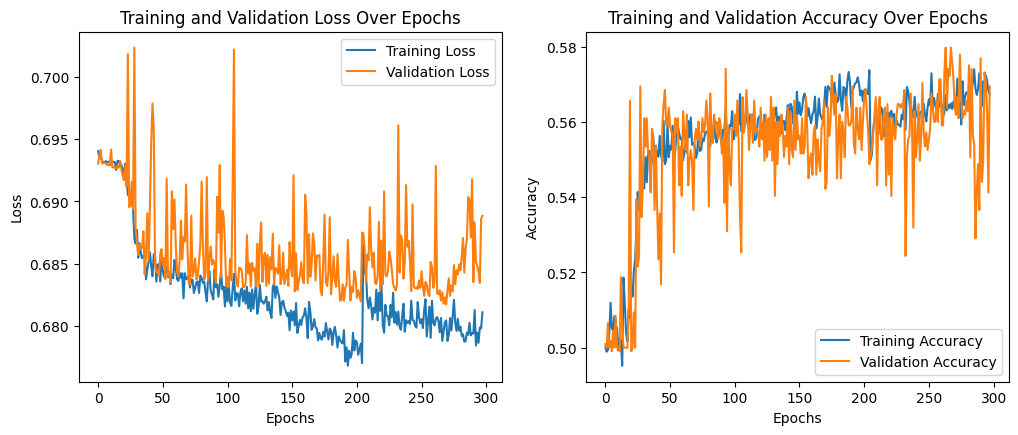

In [14]:
import matplotlib.pyplot as plt
import torch.optim as optim

# Binary Cross-Entropy Loss with Logits
criterion = nn.BCEWithLogitsLoss()

# Define the optimizer with the model's parameters and a learning rate
learning_rate = 0.0003

# Check if CUDA is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = SentimentRNN(input_size, hidden_size, output_size, num_layers, dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)


# Training parameters
num_epochs = 900
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    # Set the model to training mode
    model.train()
    for embeddings, labels in train_loader:
        # Move data to the same device as model (GPU if available)
        embeddings, labels = embeddings.to(device), labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(embeddings).squeeze()  # Output shape is (batch_size,)
        
        # Compute the loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Print the gradients
        # for name, param in model.named_parameters():
        #     print(name, param.grad)
        
        # Accumulate the loss and accuracy
        epoch_loss += loss.item() * labels.size(0)  # Multiply by batch size for total loss
        predictions = (torch.sigmoid(outputs) >= 0.5).float()  # Threshold at 0.5
        correct_predictions += (predictions == labels).sum().item()
        total_samples += labels.size(0)

    # Calculate average loss and accuracy for the epoch
    avg_loss = epoch_loss / total_samples
    accuracy = correct_predictions / total_samples
    
    # Store metrics for plotting
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}", end=" ")
    validate_model(
        model,
        val_loader,
        device,
        criterion,
        val_losses,
        val_accuracies
    )
    # Early stopping: if the moving average validation loss is increased, then stop
    if epoch > 250:
        prev_200 = val_losses[-200:-100]
        cur_200 = val_losses[-100:]
        if sum(prev_200) < sum(cur_200):
            print("Early stopping: validation loss went up")
            break
        
    
# Save the model
torch.save(model.state_dict(), 'sentiment_rnn_2hl_64_055_0006.pth')

# Plot the training and validation loss and accuracy over epochs
plt.figure(figsize=(12, 10))

# Plot Loss
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()

# Plot Training Accuracy
plt.subplot(2, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy Over Epochs")
plt.legend()

plt.show()


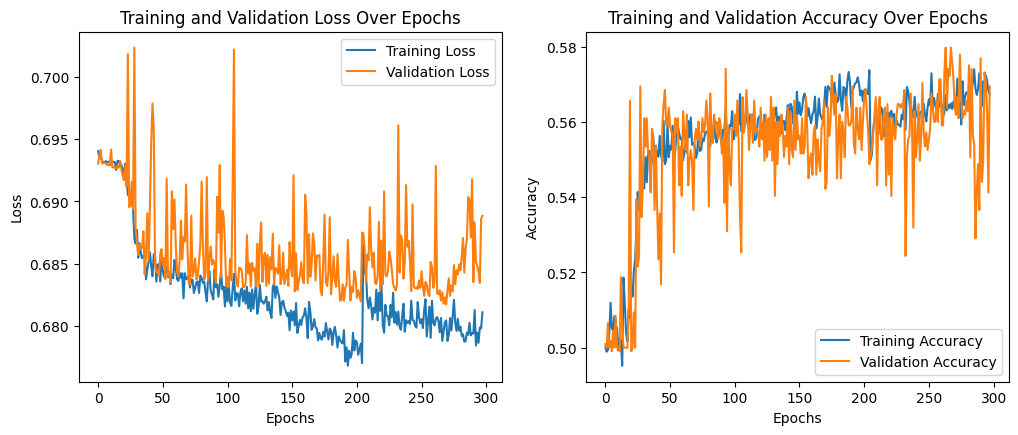

In [18]:
# Plot the training and validation loss and accuracy over epochs
plt.figure(figsize=(12, 10))

# Plot Loss
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()

# Plot Training Accuracy
plt.subplot(2, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy Over Epochs")
plt.legend()

plt.show()


In [16]:
# Save the model
# torch.save(model.state_dict(), 'sentiment_rnn_2hl_196_0003.pth')

#load the model
# model = SentimentRNN(input_size, hidden_size, output_size, num_layers, dropout).to('cuda')
# model.load_state_dict(torch.load('sentiment_rnn_2hl_196_0003.pth'))


/tmp/ipykernel_36228/3201192879.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('sentiment_rnn_2hl_196_0003.pth'))


FileNotFoundError: [Errno 2] No such file or directory: 'sentiment_rnn_2hl_196_0003.pth'

In [17]:
from datasets import load_from_disk
from gensim.models import Word2Vec


# Check if CUDA is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# This is the word2vec model
word2vec_model = Word2Vec.load('word2vec.model')

# Load the validation and test datasets
path_to_val_set = r"../tokenised_datasets/tokenised_validation_dataset"
val_dataset = load_from_disk(path_to_val_set)

path_to_test_set = r"../tokenised_datasets/tokenised_test_dataset"
test_dataset = load_from_disk(path_to_test_set)

# Test the model on the validation set
test_data = SentimentDataset(test_dataset, word2vec_model)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, collate_fn=collate_fn, num_workers=2)

# Set the model to evaluation mode
model.eval()

test_predictions = []
test_targets = []

for embeddings, labels in val_loader:
    # Move data to the same device as model
    embeddings, labels = embeddings.to(device), labels.to(device)
    
    # Forward pass
    outputs = model(embeddings).squeeze()
    
    # Store the actual and predicted labels
    predictions = (torch.sigmoid(outputs) >= 0.5).float()
    test_predictions.extend(predictions.tolist())
    test_targets.extend(labels.tolist())
    
# Calculate the test accuracy
test_predictions = np.array(test_predictions)
test_targets = np.array(test_targets)
test_accuracy = np.mean(test_predictions == test_targets)

print(f"testidation Accuracy: {test_accuracy:.4f}")

testidation Accuracy: 0.5000
